In [1]:
import numpy as np
import pandas as pd

# **Load Dataset**

In [2]:
df = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv')
df.sample(100)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
150121,0.0,1.0,1.0,1.0,33.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,4.0,8.0
207098,0.0,0.0,0.0,1.0,23.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
229663,0.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,1.0,0.0,1.0,3.0,6.0,8.0
234782,0.0,1.0,0.0,1.0,34.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,4.0,2.0,0.0,0.0,7.0,6.0,6.0
51972,0.0,1.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,8.0,0.0,0.0,1.0,1.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186809,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,5.0,8.0
25258,0.0,0.0,0.0,0.0,21.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,8.0,0.0,0.0,1.0,2.0,6.0,6.0
62769,0.0,1.0,1.0,1.0,26.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,3.0,0.0,1.0,9.0,6.0,7.0
230221,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,4.0,8.0


# **Target Column Count**

In [3]:
df["Diabetes_012"].value_counts()


Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

# **Data Preprocessing**

In [4]:
df = df.dropna(axis=1, thresh=len(df)*0.5)

# Drop rows with any missing values
df = df.dropna(axis=0)


<Axes: ylabel='count'>

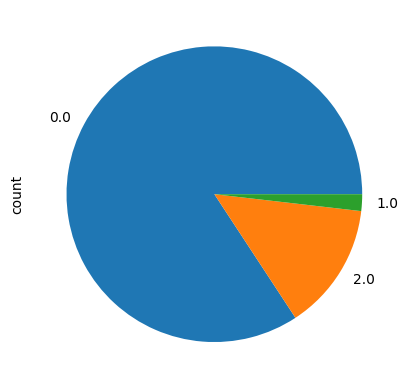

In [5]:
df['Diabetes_012'].value_counts().plot(kind='pie')

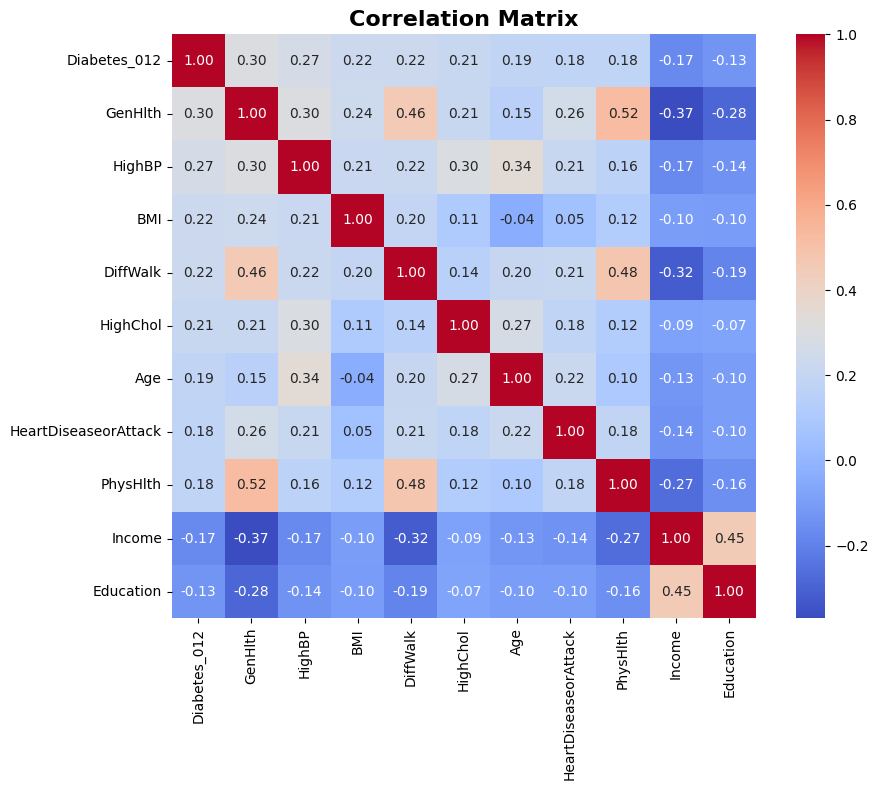

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

target = 'Diabetes_012'   # (0 = No Diabetes, 1 = Prediabetes, 2 = Diabetes)

# Correlation matrix
corr = df.corr()

top10_corr = corr[target].abs().sort_values(ascending=False).head(11)  


top10_features = top10_corr.index.tolist()
corr_top10 = df[top10_features].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_top10, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
plt.title("Correlation Matrix", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

# **Balance the dataset**

In [6]:
from sklearn.utils import resample
import pandas as pd

def expand_df(df, target_col, mode='not majority'):
    class_counts = df[target_col].value_counts()
    majority_class = class_counts.idxmax()
    max_count = class_counts.max()
    df_list = []

    for cls, count in class_counts.items():
        subset = df[df[target_col] == cls]
        if mode == 'not majority' and cls == majority_class:
            # Majority class unchanged
            df_list.append(subset)
        else:
            # Oversample minority classes
            subset_upsampled = resample(subset,
                                        replace=True,
                                        n_samples=max_count,
                                        random_state=42)
            df_list.append(subset_upsampled)

    return pd.concat(df_list).sample(frac=1, random_state=42).reset_index(drop=True)


In [7]:
df_balanced = expand_df(df, 'Diabetes_012', 'not majority')

print(df_balanced['Diabetes_012'].value_counts())


Diabetes_012
1.0    213703
2.0    213703
0.0    213703
Name: count, dtype: int64


In [8]:
y = df_balanced['Diabetes_012'].values
del df_balanced['Diabetes_012']
X = df_balanced.values
del df_balanced

In [9]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: Split the 30% temp into 15% validation and 15% test (50/50 of the temp set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Clean up temporary variables
del X, y, X_temp, y_temp

In [10]:
X_train.shape, X_val.shape, X_test.shape

((448776, 21), (96166, 21), (96167, 21))

# **Model Comparison**

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

def compare_models(task_type, models_list, metrics, 
                   X_train, y_train, X_test, y_test,
                   get_result=True):
    
    model_dict = {
        'ada': AdaBoostClassifier(random_state=42),
        'cat': CatBoostClassifier(verbose=0, random_state=42),
        'lbm': LGBMClassifier(random_state=42),
        'raf': RandomForestClassifier(random_state=42),
        'dtr': DecisionTreeClassifier(random_state=42),
        'ext': ExtraTreesClassifier(random_state=42),
        'rdg': RidgeClassifier(random_state=42),
        'per': Perceptron(random_state=42)
    }

    results = []
    for m in models_list:
        if m not in model_dict:
            print(f"⚠️ Model {m} not recognized, skipping...")
            continue

        model = model_dict[m]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        row = {'model': m}
        # overall accuracy
        row['accuracy'] = round(accuracy_score(y_test, y_pred), 4)
        # overall precision/recall/f1 (macro average)
        row['precision'] = round(precision_score(y_test, y_pred, average='macro', zero_division=0), 4)
        row['recall'] = round(recall_score(y_test, y_pred, average='macro', zero_division=0), 4)
        row['f1'] = round(f1_score(y_test, y_pred, average='macro', zero_division=0), 4)

        results.append(row)

    results_df = pd.DataFrame(results)
    
    if get_result:
        return results_df
    else:
        print(results_df)

# usage
results = compare_models(
    'clf',
    ['ada', 'cat', 'lbm', 'raf', 'dtr', 'ext', 'rdg', 'per'],
    ['acc', 'precision'],
    X_train, y_train, X_test, y_test,
    get_result=True
)

print("🔹 Overall Results:")
print(results)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 448776, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
🔹 Overall Results:
  model  accuracy  precision  recall      f1
0   ada    0.5236     0.5147  0.5236  0.5149
1   cat    0.6944     0.6951  0.6944  0.6944
2   lbm    0.5963     0.5968  0.5963  0.5951
3   raf    0.9570     0.9597  0.9570  0.9568
4   dtr    0.9352     0.9404  0.9352  0.9342
5   ext    0.9671     0.9682  0.9671  0.9670
6   rdg    0.5137     0.4989  0.5137  0.4895
7   per    0.4123     0.5395  0.4123  0.3156


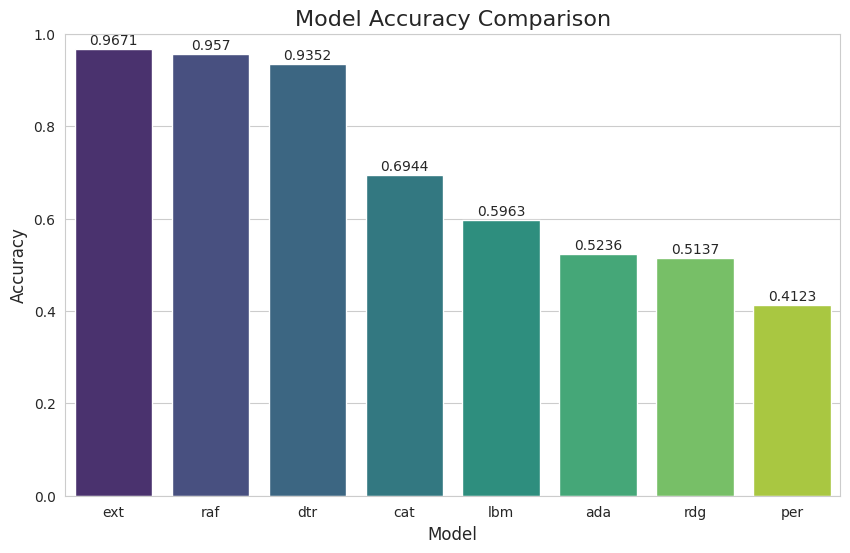

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Sort by accuracy (optional)
results_sorted = results.sort_values(by='acc', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='model', y='acc', data=results_sorted, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)  # accuracy ranges from 0 to 1
for index, value in enumerate(results_sorted['acc']):
    plt.text(index, value + 0.01, str(value), ha='center')
plt.show()


# **Best Model**

In [15]:
def get_best_model(results_df, metric, task_type, X_train, y_train, behavior='max-best'):
  
    
    if behavior == 'max-best':
        best_row = results_df.loc[results_df[metric].idxmax()]
    else:
        best_row = results_df.loc[results_df[metric].idxmin()]
    
    best_model_name = best_row['model']
    
   
    model_dict = {
        'ada': AdaBoostClassifier(random_state=42),
        'cat': CatBoostClassifier(verbose=0, random_state=42),
        'lbm': LGBMClassifier(random_state=42),
        'raf': RandomForestClassifier(random_state=42),
        'dtr': DecisionTreeClassifier(random_state=42),
        'ext': ExtraTreesClassifier(random_state=42),
        'rdg': RidgeClassifier(random_state=42),
        'per': Perceptron(random_state=42)
    }
    
    # best model retrain on full training data
    best_model = model_dict[best_model_name]
    best_model.fit(X_train, y_train)
    
    return best_model



from sklearn.metrics import accuracy_score, precision_score


best_model = get_best_model(results, 'acc', 'clf', X_train, y_train, behavior='max-best')


y_pred = best_model.predict(X_test)

# metrics calculate
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)

print("Best Model:", best_model.__class__.__name__)
print("Accuracy:", round(acc, 4))
print("Precision:", round(precision, 4))


Best Model: ExtraTreesClassifier
Accuracy: 0.9671
Precision: 0.9682


In [15]:
from sklearn.metrics import classification_report as rep

print(rep(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     32055
         1.0       0.99      1.00      1.00     32056
         2.0       0.93      0.98      0.95     32056

    accuracy                           0.97     96167
   macro avg       0.97      0.97      0.97     96167
weighted avg       0.97      0.97      0.97     96167



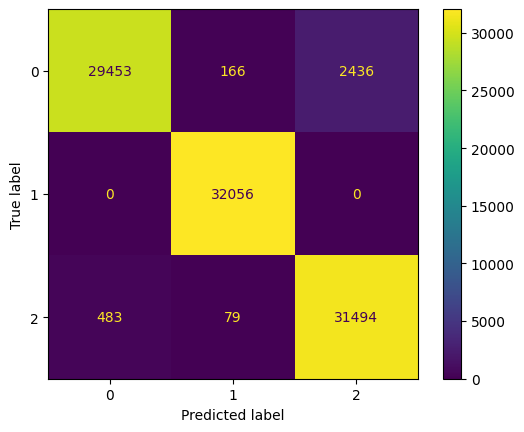

In [16]:
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import ConfusionMatrixDisplay as cmd

cm = conf(y_test, y_pred)
disp = cmd(confusion_matrix=cm)
disp.plot()

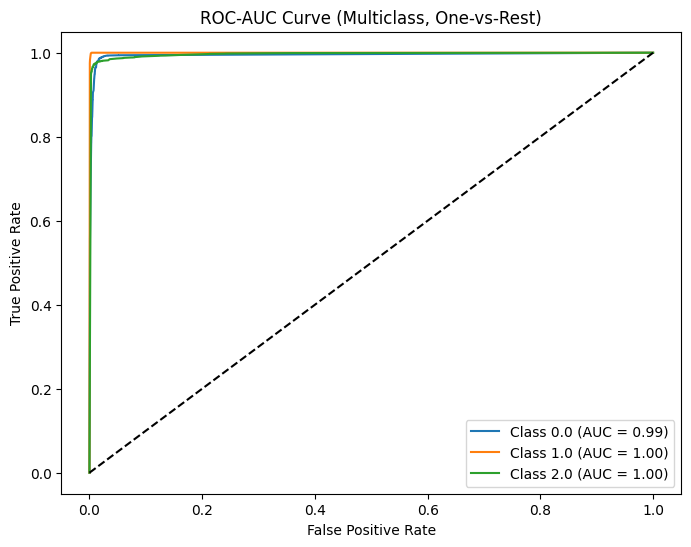

Macro-average ROC-AUC Score: 0.9968
K-fold Cross-Validation (k=5) Accuracy: 0.9557 (+/- 0.0010)


In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ---- Step 4: ROC-AUC ----
n_classes = len(np.unique(y_test))

if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)

    if n_classes > 2:
        # Multiclass (One-vs-Rest)
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'Class {np.unique(y_test)[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-AUC Curve (Multiclass, One-vs-Rest)')
        plt.legend(loc='best')
        plt.show()

        macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
        print(f"Macro-average ROC-AUC Score: {macro_auc:.4f}")

    elif n_classes == 2:
        # Binary classification
        y_prob_binary = y_prob[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_binary)
        roc_auc = roc_auc_score(y_test, y_prob_binary)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-AUC Curve (Binary)')
        plt.legend(loc='best')
        plt.show()

        print(f"ROC-AUC Score: {roc_auc:.4f}")

else:
    print("⚠️ ROC-AUC skipped (model does not support predict_proba)")

# ---- Step 5: K-fold Cross-Validation (k=5) ----
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"K-fold Cross-Validation (k=5) Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


# **Using Ensemble Stacking**

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CatBoost Accuracy: 0.9884
RandomForest Accuracy: 0.9829
DecisionTree Accuracy: 0.9772
ExtraTrees Accuracy: 0.9837

✅ Best Final Estimator: CatBoost with Accuracy = 0.9884


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     32055
         1.0       0.99      1.00      1.00     32056
         2.0       0.99      0.98      0.98     32056

    accuracy                           0.99     96167
   macro avg       0.99      0.99      0.99     96167
weighted avg       0.99      0.99      0.99     96167



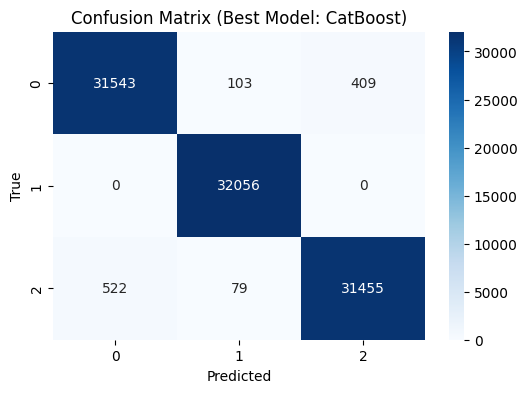

In [16]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Base models (fixed)
base_models = [
    ('raf', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)),
    ('dtr', DecisionTreeClassifier(random_state=42)),
    ('ext', ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1))
]

# Final estimators to test
final_estimators = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42, early_stopping_rounds=50),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

best_model, best_acc, best_name = None, 0, ""

# Loop through estimators and pick best one
for name, final_estimator in final_estimators.items():
    model = StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc, best_model, best_name = acc, model, name

print(f"\n✅ Best Final Estimator: {best_name} with Accuracy = {best_acc:.4f}")

# ---- Evaluate best model properly ----
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: {best_name})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


5-Fold CV Accuracy: 0.9801 ± 0.0004
Multi-class ROC-AUC = 0.9977


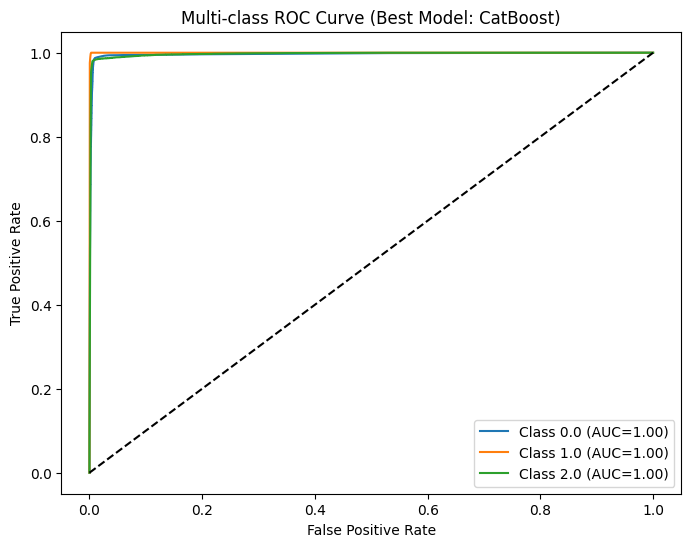

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# --- 5-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# --- Multi-class ROC-AUC preparation ---
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = best_model.predict_proba(X_test)  # shape = (n_samples, n_classes)

# Compute ROC-AUC (one-vs-rest)
roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
print(f"Multi-class ROC-AUC = {roc_auc:.4f}")

# Optional: Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC={auc(fpr, tpr):.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Multi-class ROC Curve (Best Model: {best_name})')
plt.legend()
plt.show()




In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [46]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

def plot_multiclass_curves(model, X_test, y_test, model_name):
    classes = np.unique(y_test)
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        if isinstance(y_score, list):  # CatBoost gives list for multiclass
            y_score = np.array([arr[:,1] for arr in y_score]).T
    else:
        y_score = model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = y_score[:, np.newaxis]

    # ---- ROC Curve ----
    plt.figure(figsize=(7,5))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1], color='red', linestyle='--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.show()

    # ---- Precision-Recall Curve ----
    plt.figure(figsize=(7,5))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, lw=2, label=f"Class {classes[i]} (AP={avg_precision:.2f})")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='lower left')
    plt.show()


=== Best from compare_models (ExtraTreesClassifier) ===
Accuracy: 0.9671
Macro Precision: 0.9682

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     32055
         1.0       0.99      1.00      1.00     32056
         2.0       0.93      0.98      0.95     32056

    accuracy                           0.97     96167
   macro avg       0.97      0.97      0.97     96167
weighted avg       0.97      0.97      0.97     96167



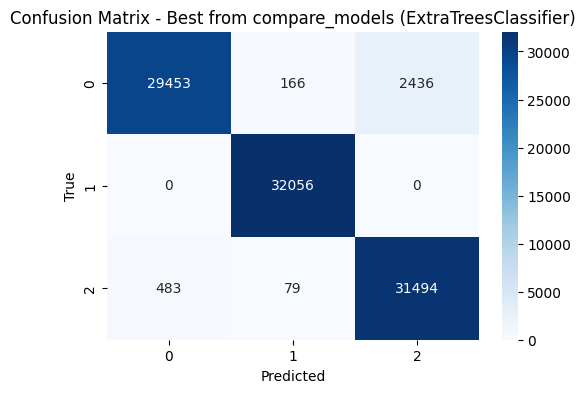

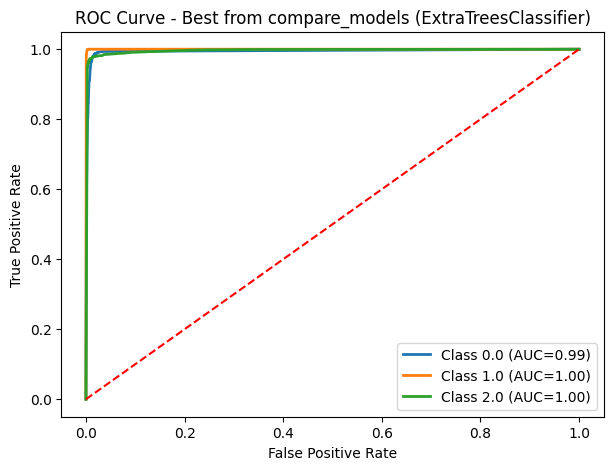

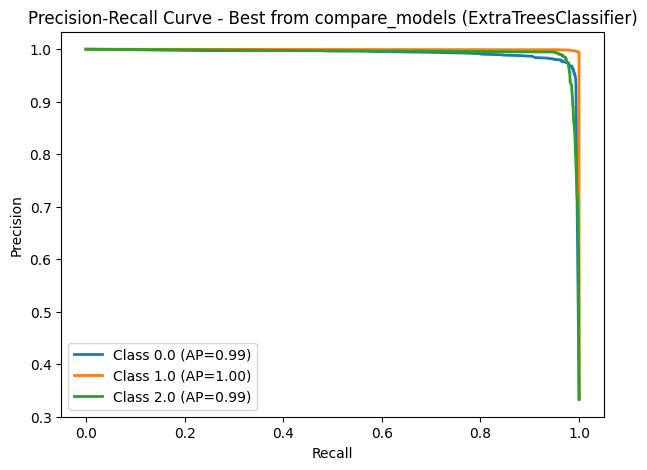

=== Best from Stacking (CatBoost) ===
Accuracy: 0.9884
Macro Precision: 0.9884

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     32055
         1.0       0.99      1.00      1.00     32056
         2.0       0.99      0.98      0.98     32056

    accuracy                           0.99     96167
   macro avg       0.99      0.99      0.99     96167
weighted avg       0.99      0.99      0.99     96167



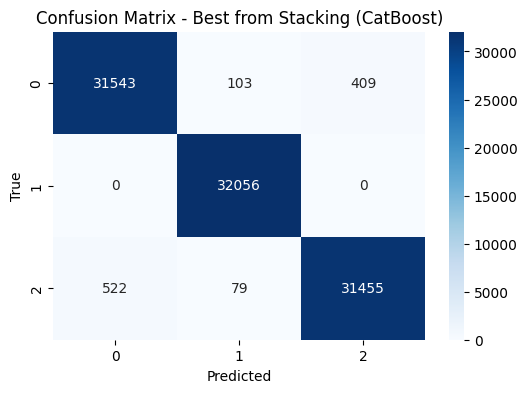

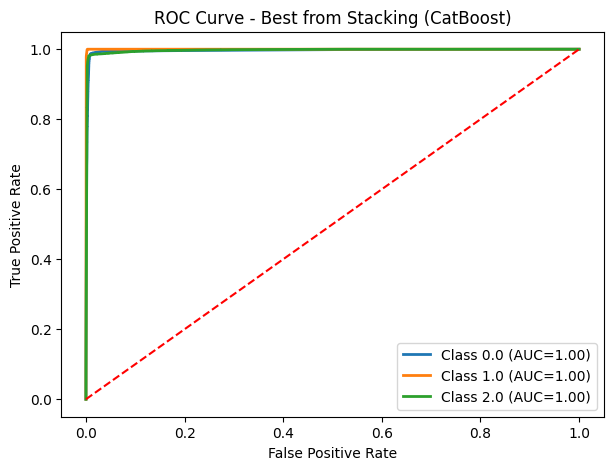

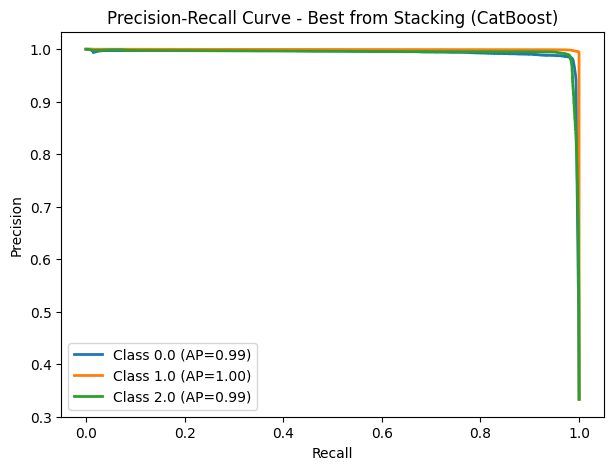

In [47]:
# 1️⃣ First code best model
best_model_1 = get_best_model(results, 'acc', 'clf', X_train, y_train, behavior='max-best')
evaluate_classification(best_model_1, X_test, y_test, model_name=f"Best from compare_models ({best_model_1.__class__.__name__})")
plot_multiclass_curves(best_model_1, X_test, y_test, model_name=f"Best from compare_models ({best_model_1.__class__.__name__})")

# 2️⃣ Second code best stacking model
evaluate_classification(best_model, X_test, y_test, model_name=f"Best from Stacking ({best_name})")
plot_multiclass_curves(best_model, X_test, y_test, model_name=f"Best from Stacking ({best_name})")


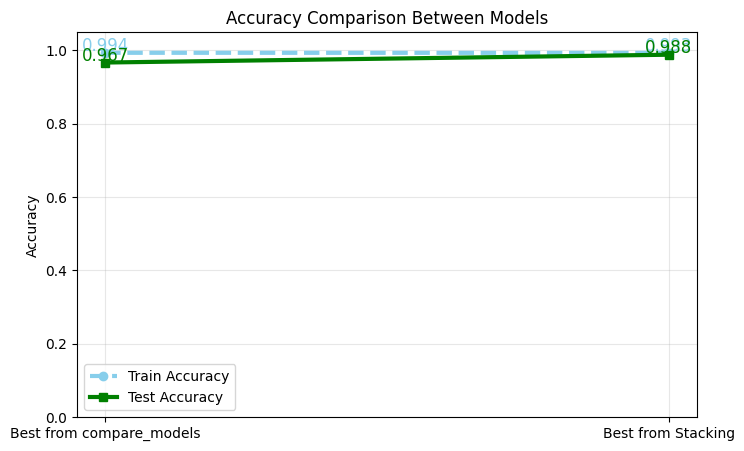

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def simple_accuracy_curve(models, model_names, X_train, y_train, X_test, y_test):
    train_acc = []
    test_acc = []
    
    for model in models:
        model.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, model.predict(X_train)))
        test_acc.append(accuracy_score(y_test, model.predict(X_test)))
    
    x = np.arange(len(models))
    
    plt.figure(figsize=(8,5))
    plt.plot(x, train_acc, linestyle='--', marker='o', color='skyblue', label='Train Accuracy', linewidth=3)
    plt.plot(x, test_acc, linestyle='-', marker='s', color='green', label='Test Accuracy', linewidth=3)
    
    # Accuracy labels
    for i in range(len(models)):
        plt.text(x[i], train_acc[i]+0.005, f"{train_acc[i]:.3f}", ha='center', color='skyblue', fontsize=12)
        plt.text(x[i], test_acc[i]+0.005, f"{test_acc[i]:.3f}", ha='center', color='green', fontsize=12)
    
    plt.xticks(x, model_names)
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison Between Models")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# Use with your two best models
simple_accuracy_curve(
    models=[best_model_1, best_model],
    model_names=['Best from compare_models', 'Best from Stacking'],
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test
)


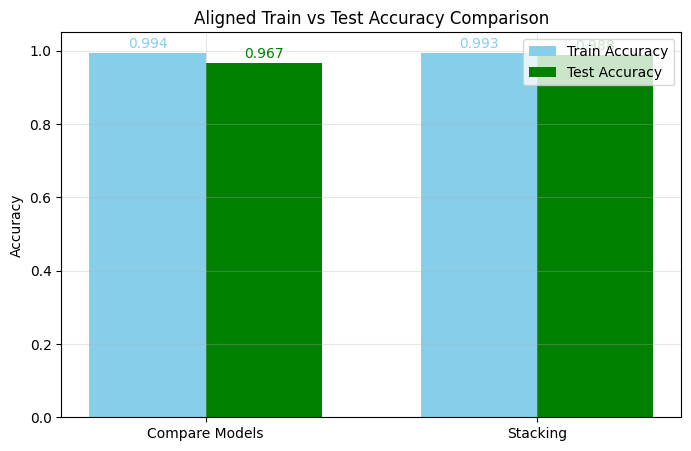

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def aligned_bar_accuracy(models, model_names, X_train, y_train, X_test, y_test):
    train_acc = []
    test_acc = []

    for model in models:
        model.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, model.predict(X_train)))
        test_acc.append(accuracy_score(y_test, model.predict(X_test)))

    x = np.arange(len(models))  # label positions
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(8,5))
    
    # Side-by-side bars
    bars1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='skyblue')
    bars2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='green')

    # Add labels on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.3f}', ha='center', va='bottom', color='skyblue', fontsize=10)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.3f}', ha='center', va='bottom', color='green', fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Accuracy')
    ax.set_title('Aligned Train vs Test Accuracy Comparison')
    ax.legend()
    plt.grid(alpha=0.3)
    plt.show()


aligned_bar_accuracy(
    models=[best_model_1, best_model],
    model_names=['Compare Models', 'Stacking'],
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test
)


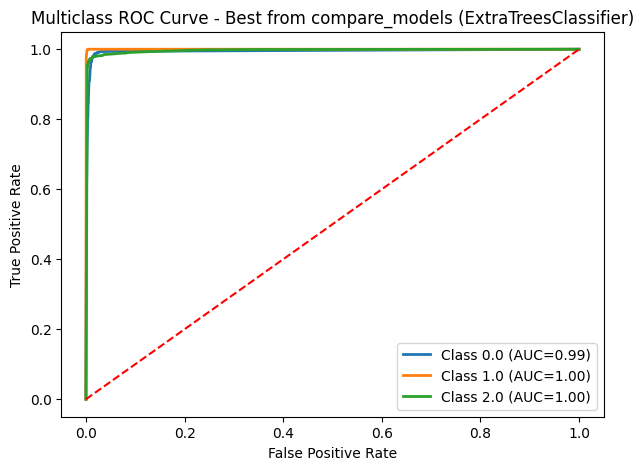

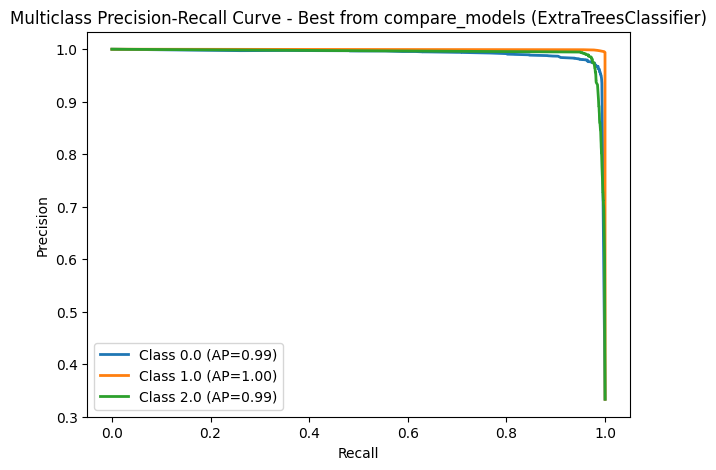

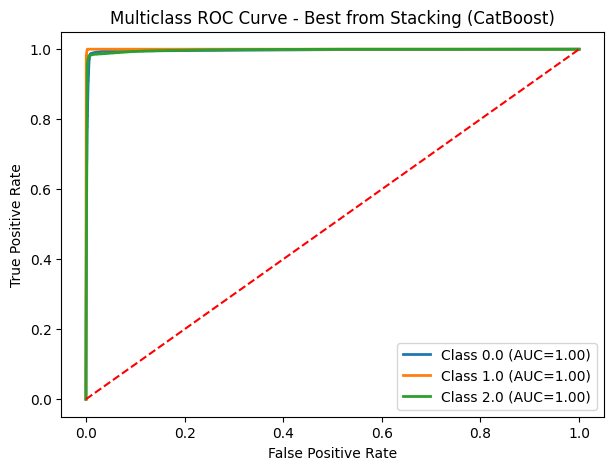

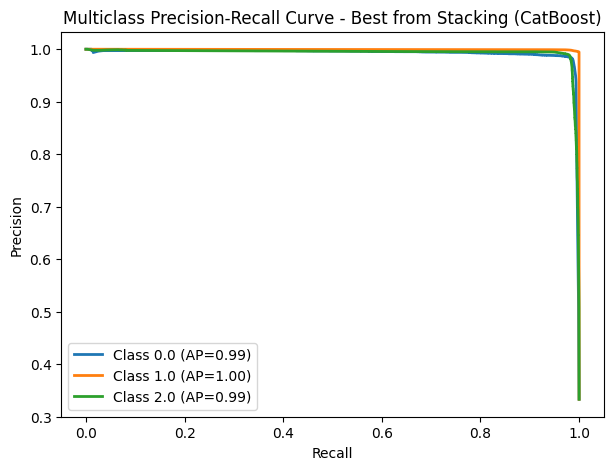

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_multiclass_curves(model, X_test, y_test, model_name):
    classes = np.unique(y_test)
    n_classes = len(classes)

    # Binarize the output for multiclass
    y_test_bin = label_binarize(y_test, classes=classes)

    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        # Some models return list of arrays for multiclass (e.g., CatBoost)
        if isinstance(y_score, list):
            y_score = np.array([arr[:,1] for arr in y_score]).T
    else:
        y_score = model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = y_score[:, np.newaxis]

    # ---- ROC Curve ----
    plt.figure(figsize=(7,5))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1], color='red', linestyle='--')
    plt.title(f"Multiclass ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.show()

    # ---- Precision-Recall Curve ----
    plt.figure(figsize=(7,5))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, lw=2, label=f"Class {classes[i]} (AP={avg_precision:.2f})")
    plt.title(f"Multiclass Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='lower left')
    plt.show()

# 1️⃣ First code best model
best_model_1 = get_best_model(results, 'acc', 'clf', X_train, y_train, behavior='max-best')
plot_multiclass_curves(best_model_1, X_test, y_test, model_name=f"Best from compare_models ({best_model_1.__class__.__name__})")

# 2️⃣ Second code best stacking model
plot_multiclass_curves(best_model, X_test, y_test, model_name=f"Best from Stacking ({best_name})")


# **HyperParameter Tuning(GridSearchCV)**

In [20]:

# from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
# from sklearn.tree import DecisionTreeClassifier
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
# # from sklearn.preprocessing import label_binarize
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # ---------------------------
# # 1️⃣ Base models (production-size)
# # ---------------------------
# base_models = [
#     ('raf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
#     ('dtr', DecisionTreeClassifier(random_state=42)),
#     ('ext', ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1))
# ]

# # ---------------------------
# # 2️⃣ Stacking with CatBoost
# # ---------------------------
# stack_model = StackingClassifier(
#     estimators=base_models,
#     final_estimator=CatBoostClassifier(verbose=0, random_state=42),
#     cv=2
# )

# # ---------------------------
# # 3️⃣ Grid Search Parameters
# # ---------------------------
# param_grid = {
#     'final_estimator__depth': [3, 5, 7, 9],
#     'final_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'final_estimator__iterations': [200, 300, 400]
# }

# # ---------------------------
# # 4️⃣ GridSearchCV with 5-fold inner CV
# # ---------------------------
# grid = GridSearchCV(
#     estimator=stack_model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=5,          # <-- inner 5-fold CV for hyperparameter tuning
#     n_jobs=-1,
#     verbose=2
# )

# # ---------------------------
# # 5️⃣ Fit GridSearch
# # ---------------------------
# grid.fit(X_train, y_train)

# # ---------------------------
# # 6️⃣ Best Model & Parameters
# # ---------------------------
# best_stack_model = grid.best_estimator_
# print("✅ Best Parameters:", grid.best_params_)
# print("Best CV Accuracy:", grid.best_score_)

# # ---------------------------
# # 7️⃣ Test Set Evaluation
# # ---------------------------
# y_pred = best_stack_model.predict(X_test)
# print("\nTest Accuracy:", accuracy_score(y_test, y_pred))

# # Classification Report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix (Best Model)')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # ---------------------------
# # 8️⃣ 5-Fold CV on entire training set
# # ---------------------------
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(best_stack_model, X_train, y_train, cv=cv, scoring='accuracy')
# print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# # ---------------------------
# # 9️⃣ Multi-class ROC-AUC
# # ---------------------------
# classes = np.unique(y_train)
# y_test_bin = label_binarize(y_test, classes=classes)
# y_prob = best_stack_model.predict_proba(X_test)

# roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
# print(f"Multi-class ROC-AUC: {roc_auc:.4f}")

# plt.figure(figsize=(8,6))
# for i, class_label in enumerate(classes):
#     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
#     plt.plot(fpr, tpr, label=f'Class {class_label} (AUC={auc(fpr, tpr):.2f})')

# plt.plot([0,1],[0,1],'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Multi-class ROC Curve (Best Model)')
# plt.legend()
# plt.show()


# **HyperParameter Tuning(RandomSearchCV)**

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

✅ Best Params: {'final_estimator__learning_rate': 0.05, 'final_estimator__iterations': 300, 'final_estimator__depth': 9}
CV Accuracy: 0.9700652441307022


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Test Accuracy: 0.9887071448625828

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     32055
         1.0       0.99      1.00      1.00     32056
         2.0       0.99      0.98      0.98     32056

    accuracy                           0.99     96167
   macro avg       0.99      0.99      0.99     96167
weighted avg       0.99      0.99      0.99     96167



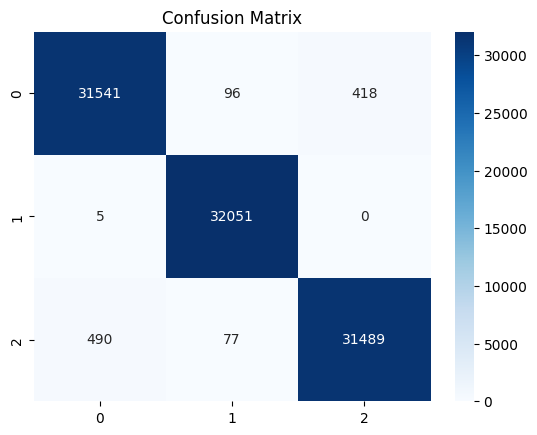

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Stratified 3-Fold CV: 0.9696 ± 0.0001
Multi-class ROC-AUC: 0.9978


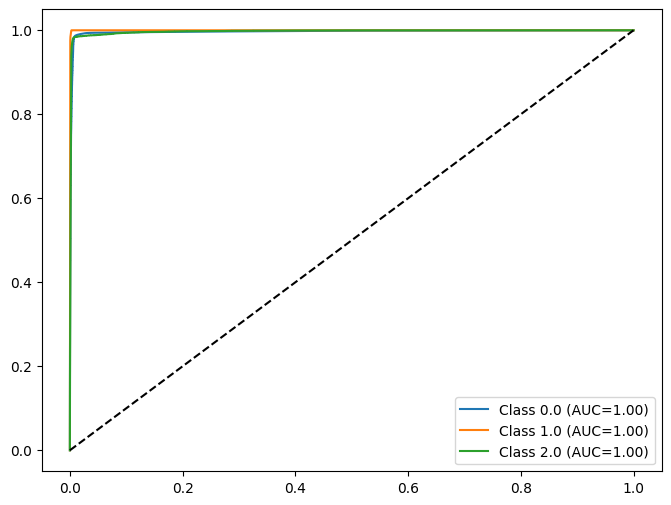

In [21]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# Base + Stacking Model
# ---------------------------
base_models = [
    ('raf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ('dtr', DecisionTreeClassifier(random_state=42)),
    ('ext', ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1))
]

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=CatBoostClassifier(verbose=0, random_state=42),
    cv=2
)

# ---------------------------
# RandomizedSearchCV
# ---------------------------
param_dist = {
    'final_estimator__depth': [3, 5, 7, 9],
    'final_estimator__learning_rate': [0.01, 0.05, 0.1],
    'final_estimator__iterations': [200, 300, 400]
}

random_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_dist,
    n_iter=20,          
    scoring='accuracy',
    cv=3,               
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

# ---------------------------
# Train & Best Model
# ---------------------------
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

print("✅ Best Params:", random_search.best_params_)
print("CV Accuracy:", random_search.best_score_)

# ---------------------------
# Test Set Evaluation
# ---------------------------
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ---------------------------
# Cross-validation (external)
# ---------------------------
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Stratified 3-Fold CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ---------------------------
# Multi-class ROC-AUC
# ---------------------------
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)
    y_bin = label_binarize(y_test, classes=np.unique(y_train))
    roc_auc = roc_auc_score(y_bin, y_prob, multi_class='ovr')
    print(f"Multi-class ROC-AUC: {roc_auc:.4f}")

    plt.figure(figsize=(8,6))
    for i, label in enumerate(np.unique(y_train)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {label} (AUC={auc(fpr, tpr):.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.legend(); plt.show()


# **HyperParameter Tuning(Optuna)**

[I 2025-09-19 06:26:36,626] A new study created in memory with name: no-name-e75c5c31-63e8-4cda-a5aa-e840cd5f5c2f
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-09-19 06:37:23,700] Trial 0 finished with value: 0.969271975328449 and parameter

✅ Best Params: {'depth': 10, 'learning_rate': 0.06427630533027896, 'iterations': 313}
Best CV Accuracy: 0.969530456174127


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Test Accuracy: 0.9885927605103622

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     32055
         1.0       0.99      1.00      1.00     32056
         2.0       0.99      0.98      0.98     32056

    accuracy                           0.99     96167
   macro avg       0.99      0.99      0.99     96167
weighted avg       0.99      0.99      0.99     96167



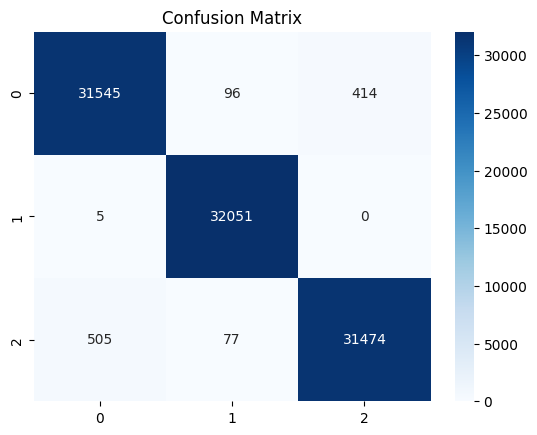

Multi-class ROC-AUC: 0.9978


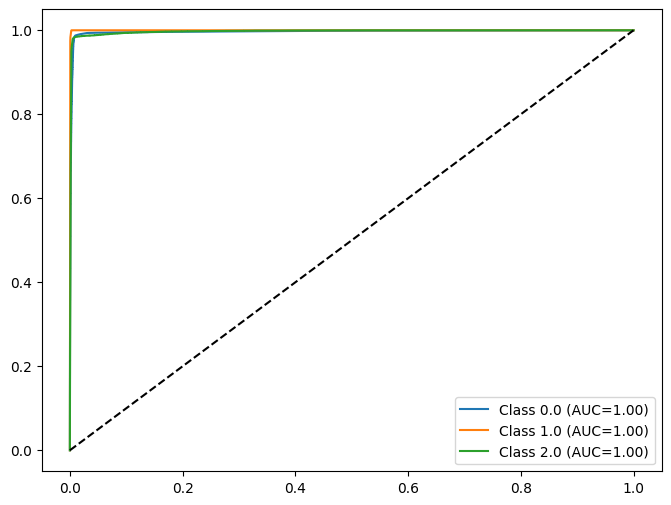

In [9]:
import optuna
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# Base Models
# ---------------------------
base_models = [
    ('raf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ('dtr', DecisionTreeClassifier(random_state=42)),
    ('ext', ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1))
]

# ---------------------------
# Optuna Objective Function
# ---------------------------
def objective(trial):
    # CatBoost Hyperparameters to tune
    depth = trial.suggest_int("depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    iterations = trial.suggest_int("iterations", 200, 500)

    stack_model = StackingClassifier(
        estimators=base_models,
        final_estimator=CatBoostClassifier(
            verbose=0,
            random_state=42,
            depth=depth,
            learning_rate=learning_rate,
            iterations=iterations
        ),
        cv=2
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(stack_model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    return scores.mean()

# ---------------------------
# Run Optuna Study
# ---------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  

print("✅ Best Params:", study.best_params)
print("Best CV Accuracy:", study.best_value)

# ---------------------------
# Train Best Model on Full Training Data
# ---------------------------
best_params = study.best_params
best_model = StackingClassifier(
    estimators=base_models,
    final_estimator=CatBoostClassifier(
        verbose=0,
        random_state=42,
        depth=best_params["depth"],
        learning_rate=best_params["learning_rate"],
        iterations=best_params["iterations"]
    ),
    cv=2
)

best_model.fit(X_train, y_train)

# ---------------------------
# Test Set Evaluation
# ---------------------------
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ---------------------------
# Multi-class ROC-AUC
# ---------------------------
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)
    y_bin = label_binarize(y_test, classes=np.unique(y_train))
    roc_auc = roc_auc_score(y_bin, y_prob, multi_class='ovr')
    print(f"Multi-class ROC-AUC: {roc_auc:.4f}")

    plt.figure(figsize=(8,6))
    for i, label in enumerate(np.unique(y_train)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {label} (AUC={auc(fpr, tpr):.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.legend(); plt.show()


# **Explainable AI(XAI)**

In [17]:
import pandas as pd

# Option 1: Extract from df (if available after preprocessing)
try:
    feature_names = df.drop('Diabetes_012', axis=1).columns
except NameError:
    # Option 2: Manually define feature names (based on diabetes dataset)
    feature_names = [
        'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
        'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
        'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
        'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
    ]

In [20]:
!pip install shap

# **Permutation Importances**

Calculating permutation importance...
Permutation
      Feature  Importance Mean  Importance Std
3         BMI         0.610167        0.000885
18        Age         0.572174        0.000601
20     Income         0.547458        0.000736
13    GenHlth         0.486455        0.000954
19  Education         0.460825        0.001347
15   PhysHlth         0.444543        0.000880
14   MentHlth         0.357298        0.000763
4      Smoker         0.320651        0.001371
17        Sex         0.318061        0.001084
1    HighChol         0.315710        0.000727


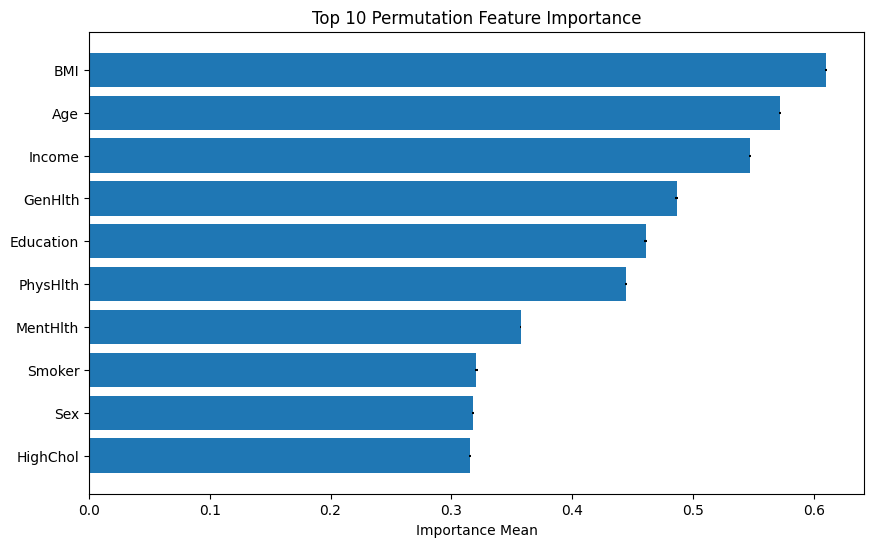

In [32]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress DataConversionWarning

print("Calculating permutation importance...")
r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

# Create DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': r.importances_mean,
    'Importance Std': r.importances_std
}).sort_values('Importance Mean', ascending=False)

# Select only top 10 features
top10_df = perm_importance_df.head(10)

print("Permutation")
print(top10_df)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top10_df['Feature'], top10_df['Importance Mean'], xerr=top10_df['Importance Std'])
plt.xlabel('Importance Mean')
plt.title('Top 10 Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


# **SHAP**

Calculating SHAP values with KernelExplainer... (this may take time)


  0%|          | 0/200 [00:00<?, ?it/s]

SHAP
      Feature  Mean_SHAP
3         BMI   0.056617
13    GenHlth   0.048758
18        Age   0.047039
20     Income   0.041188
0      HighBP   0.038543
19  Education   0.038076
1    HighChol   0.037706
15   PhysHlth   0.031025
16   DiffWalk   0.029229
14   MentHlth   0.029195


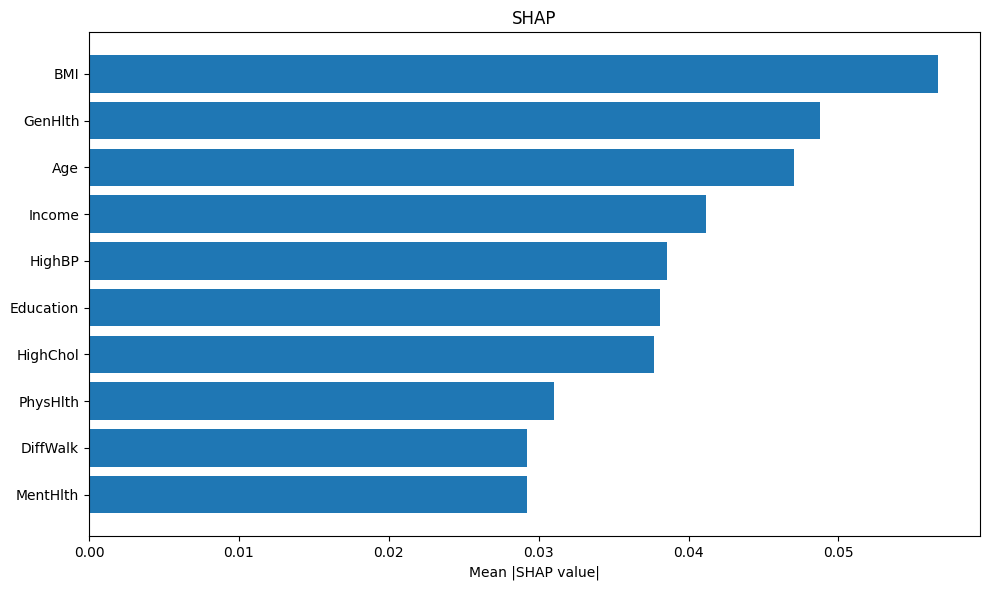

In [33]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# ---------------------------
# STEP 1: Feature Names
# ---------------------------
try:
    feature_names = df.drop('Diabetes_012', axis=1).columns
except NameError:
    feature_names = [
        'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
        'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
        'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
        'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
    ]

# ---------------------------
# STEP 2: SHAP with KernelExplainer
# ---------------------------
print("Calculating SHAP values with KernelExplainer... (this may take time)")

# Background sample
X_background = shap.utils.sample(X_test, 100, random_state=42)
explainer = shap.KernelExplainer(best_model.predict_proba, X_background)

# Sample test data
X_sample = shap.utils.sample(X_test, 200, random_state=42)
shap_values = explainer.shap_values(X_sample, nsamples=100)

# ---------------------------
# STEP 3: Overall SHAP importance (no class split)
# ---------------------------
# shap_values is a list (one per class) → take absolute mean across all classes
mean_abs_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)

shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_abs_shap
}).sort_values('Mean_SHAP', ascending=False)

# Keep only top 10
top10_df = shap_importance_df.head(10)

print("SHAP")
print(top10_df)

# ---------------------------
# STEP 4: Plot like permutation
# ---------------------------
plt.figure(figsize=(10, 6))
plt.barh(top10_df['Feature'], top10_df['Mean_SHAP'])
plt.xlabel('Mean |SHAP value|')
plt.title('SHAP')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [25]:
!pip install lime

# **LIME**

Top 10 LIME Importances (clean feature names):
        Feature  Importance
0           Age    0.001605
1           BMI    0.001021
2        Income    0.000883
3  PhysActivity    0.000859
4       GenHlth    0.000731
5     Education    0.000675
6          0.00    0.000652
7      HighChol    0.000635
8      PhysHlth    0.000546
9          0.00    0.000541


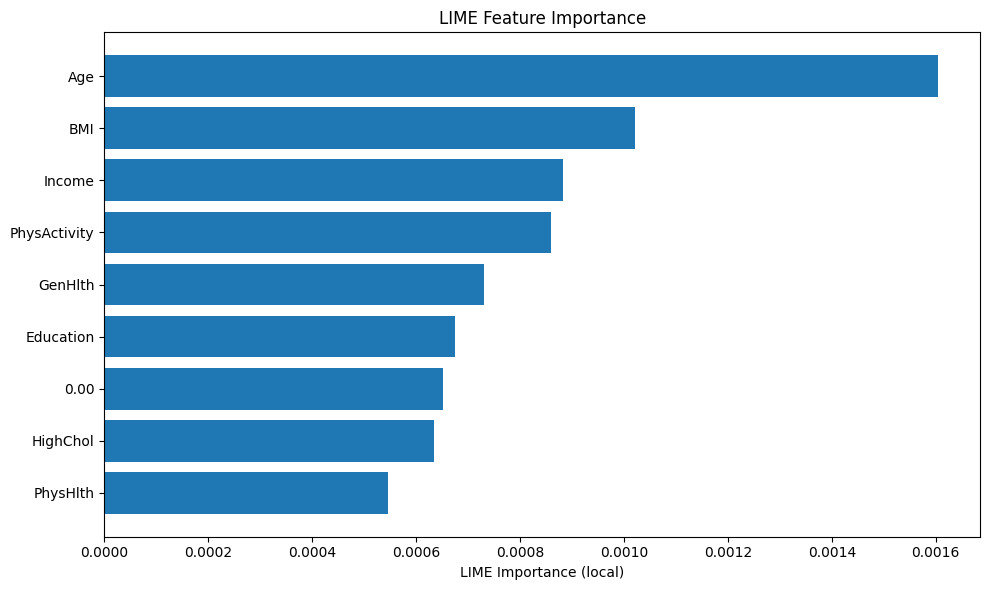

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from lime.lime_tabular import LimeTabularExplainer

warnings.filterwarnings("ignore", category=UserWarning)

# ---------------------------
# STEP 1: Feature Names
# ---------------------------
try:
    feature_names = df.drop('Diabetes_012', axis=1).columns
except NameError:
    feature_names = [
        'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
        'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
        'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
        'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
    ]

# ---------------------------
# STEP 2: Ensure X_test is DataFrame
# ---------------------------
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ---------------------------
# STEP 3: LIME Explainer Setup
# ---------------------------
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=['Class 0', 'Class 1', 'Class 2'],
    mode='classification'
)

# ---------------------------
# STEP 4: Pick one instance
# ---------------------------
i = 0  # index of instance from test set
exp = explainer.explain_instance(
    data_row=X_test_df.iloc[i].values,
    predict_fn=best_model.predict_proba,
    num_features=10  # Top 10 features
)

# ---------------------------
# STEP 5: Convert Explanation to DataFrame (only feature names)
# ---------------------------
lime_importance = pd.DataFrame(exp.as_list(), columns=['Feature', 'Importance'])
lime_importance['Importance'] = lime_importance['Importance'].astype(float)

# 🔹 Keep only feature names (strip out any thresholds/conditions)
lime_importance['Feature'] = lime_importance['Feature'].apply(lambda x: x.split()[0])

print("Top 10 LIME Importances (clean feature names):")
print(lime_importance)

# ---------------------------
# STEP 6: Plot
# ---------------------------
plt.figure(figsize=(10, 6))
plt.barh(lime_importance['Feature'], lime_importance['Importance'])
plt.xlabel("LIME Importance (local)")
plt.title(f"LIME Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
